<a href="https://colab.research.google.com/github/open-mmlab/mmclassification/blob/master/docs_zh-CN/tutorials/MMClassification_python_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMClassification Python API 教程

在本教程中会介绍如下内容：

* 如何安装 MMClassification
* 使用 Python API 进行模型推理
* 使用 Python API 进行模型微调

## 安装 MMClassification

在使用 MMClassification 之前，我们需要配置环境，步骤如下：

- 安装 Python, CUDA, C/C++ compiler 和 git
- 安装 PyTorch (CUDA 版)
- 安装 mmcv
- 克隆 mmcls github 代码库然后安装

因为我们在 Google Colab 进行实验，Colab 已经帮我们完成了基本的配置，我们可以直接跳过前面两个步骤 。

### 检查环境

In [7]:
%cd /content

/content


In [8]:
!pwd

/content


In [9]:
# 检查 nvcc 版本
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [10]:
# 检查 GCC 版本
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [11]:
# 检查 PyTorch 的安装情况
import torch, torchvision
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


### 安装 MMCV

MMCV 是 OpenMMLab 代码库的基础库。Linux 环境的安装 whl 包已经提前打包好，大家可以直接下载安装。

需要注意 PyTorch 和 CUDA 版本，确保能够正常安装。

在前面的步骤中，我们输出了环境中 CUDA 和 PyTorch 的版本，分别是 11.1 和 1.9.0，我们需要选择相应的 MMCV 版本。

另外，也可以安装完整版的 MMCV-full，它包含所有的特性以及丰富的开箱即用的 CUDA 算子。需要注意的是完整版本可能需要更长时间来编译。

In [17]:
# 安装 mmcv
!pip install mmcv -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu110/torch1.9.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |████████████████████████████████| 352 kB 5.2 MB/s 
     |████████████████████████████████| 185 kB 49.9 MB/s 
  Created wheel for mmcv: filename=mmcv-1.3.15-py2.py3-none-any.whl size=509835 sha256=793fe3796421336ca7a7740a1397a54016ba71ce95fd80cb80a116644adb4070
  Stored in directory: /root/.cache/pip/wheels/b2/f4/4e/8f6d2dd2bef6b7eb8c89aa0e5d61acd7bff60aaf3d4d4b29b0
Successfully built mmcv


### 克隆并安装 MMClassification

接着，我们从 github 上克隆下 mmcls 最新代码库并进行安装。

In [12]:
# 下载 mmcls 代码库
!git clone https://github.com/open-mmlab/mmclassification.git
%cd mmclassification/

# 从源码安装 MMClassification
!pip install -e . 

Cloning into 'mmclassification'...
remote: Enumerating objects: 4152, done.
remote: Counting objects: 100% (994/994), done.
remote: Compressing objects: 100% (576/576), done.
remote: Total 4152 (delta 476), reused 765 (delta 401), pack-reused 3158
Receiving objects: 100% (4152/4152), 8.20 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (2524/2524), done.


In [18]:
# 检查 MMClassification 的安装情况
import mmcls
print(mmcls.__version__)

0.16.0


## 使用 Python API 进行模型推理

MMClassification 提供很多预训练好的模型，可以访问链接查看[模型库](https://mmclassification.readthedocs.io/zh_CN/latest/model_zoo.html)。
绝大部分模型都能够复现原始论文的精度，或者达到更高的精度。
我们能够直接使用这些模型进行推理计算。

在使用预训练模型之前，我们需要进行如下操作:

- 准备模型
  - 准备 config 配置文件 
  - 准备模型权重参数文件
- 构建模型
- 进行推理计算

In [19]:
# 获取示例图片
!wget https://www.dropbox.com/s/k5fsqi6qha09l1v/banana.png?dl=0 -O demo/banana.png

--2021-10-21 03:52:36--  https://www.dropbox.com/s/k5fsqi6qha09l1v/banana.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k5fsqi6qha09l1v/banana.png [following]
--2021-10-21 03:52:36--  https://www.dropbox.com/s/raw/k5fsqi6qha09l1v/banana.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc10f85c3c33c4b5233bac4d074e.dl.dropboxusercontent.com/cd/0/inline/BYYklQk6LNPXNm7o5xE_fxE2GA9reePyNajQgoe9roPlSrtsJd4WN6RVww7zrtNZWFq8iZv349MNQJlm7vVaqRBxTcd0ufxkqbcJYJvOrORpxOPV7mHmhMjKYUncez8YNqELGwDd-aeZqLGKBC8spSnx/file# [following]
--2021-10-21 03:52:36--  https://uc10f85c3c33c4b5233bac4d074e.dl.dropboxusercontent.com/cd/0/inline/BYYklQk6LNPXNm7o5xE_fxE2GA9reePyNajQgoe9roPlSrtsJd4WN6RVww7zrtNZWFq8iZv349MNQJlm7vVaqRBxTcd

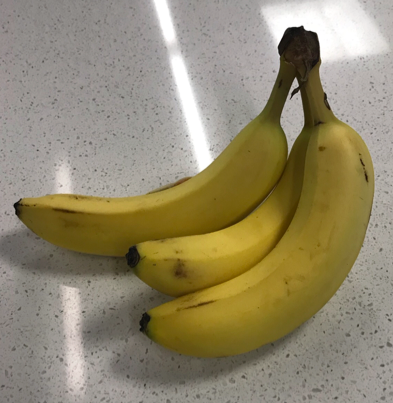

In [20]:
from PIL import Image
Image.open('demo/banana.png')

### 准备配置文件和模型权重文件

预训练模型通过配置文件和模型权重文件来定义。配置文件定义了模型结构，模型权重文件保存了训练好的模型参数。

在 GitHub 上 MMClassification 通过不同的页面来提供预训练模型。
比如, MobileNetV2 的配置文件和模型权重文件就在这个[链接](https://github.com/open-mmlab/mmclassification/tree/master/configs/mobilenet_v2)下。

我们在 MMClassification 库中已经内置了大量模型训练所需要的配置文件，可以直接读取。而模型权重文件则需要下载，方便的是，我们的 API 提供了读取模型权重 url 的功能，因此可以直接以 url 的方式指定模型权重文件。

In [21]:
# 检查确保配置文件存在
!ls configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py

# 指明配置文件和权重参数文件的路径
# 其中，权重参数文件的路径可以是一个 url，会在加载权重时自动下载。
config_file = 'configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py'
checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'

configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py


### 进行模型推理

MMClassification 提供了 high level 的 Python API 用来进行推理计算. 

首先，我们构建模型。

In [22]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot

# 指明设备，如果你没有开启 GPU，可以使用 CPU， `device='cpu'`.
device = 'cuda:0'
# device = 'cpu'
# 通过配置文件和权重参数文件构建模型
model = init_model(config_file, checkpoint_file, device=device)

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarni

Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


  0%|          | 0.00/13.5M [00:00<?, ?B/s]

/content/mmclassification/mmcls/apis/inference.py:44: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [23]:
# 模型的继承关系
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

In [24]:
# 在单张图片上展示模型的分类效果
img = 'demo/banana.png'
img_array =  mmcv.imread(img)
result = inference_model(model, img_array)
result

{'pred_class': 'banana', 'pred_label': 954, 'pred_score': 0.9999284744262695}

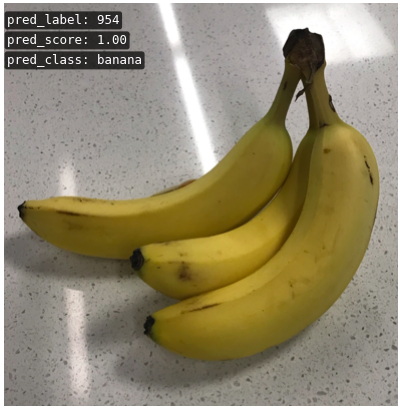

In [25]:
%matplotlib inline
# 可视化分类结果
show_result_pyplot(model, img, result)

## 使用 Python API 进行模型微调

模型微调是将预训练好的模型在特定的数据集上对模型参数进行非常精细调整的过程，最终让预训练的模型能够适配新的数据集及对应的任务。相比于模型的训练过程，模型微调大大降低了训练的时间，并减少了数据量很小的数据集在训练过程中会出现的过拟合问题。

模型微调的基本步骤如下：

1. 准备新数据集并满足 MMClassification 的要求
2. 根据数据集修改训练配置 
3. 进行训练和验证

更多细节可以查看 [文档](https://mmclassification.readthedocs.io/zh_CN/latest/tutorials/finetune.html).

### 准备数据集并满足 MMClassification 的要求

这里我们下载猫狗分类数据集，关于数据集格式的详细介绍参考 [tools 教程](https://colab.research.google.com/github/open-mmlab/mmclassification/blob/master/docs_zh-CN/tutorials/MMClassification_tools_cn.ipynb)

In [29]:
# 下载分类数据集文件
!wget https://www.dropbox.com/s/wml49yrtdo53mie/cats_dogs_dataset_reorg.zip?dl=0 -O cats_dogs_dataset.zip
!mkdir -p data
!unzip -qo cats_dogs_dataset.zip -d ./data/

--2021-10-21 03:57:58--  https://www.dropbox.com/s/wml49yrtdo53mie/cats_dogs_dataset_reorg.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wml49yrtdo53mie/cats_dogs_dataset_reorg.zip [following]
--2021-10-21 03:57:58--  https://www.dropbox.com/s/raw/wml49yrtdo53mie/cats_dogs_dataset_reorg.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfd8157272a6270e100392293da.dl.dropboxusercontent.com/cd/0/inline/BYbFG6Zo1S3l2kJtqLrJIne9lTLgQn-uoJxmUjhLSkp36V7AoiwlyR2gP0XVoUQt9WzF2ZsmeERagMy7rpsNoIYG4MjsYA90i_JsarFDs9PHhXHw9qwHpHqBvgd4YU_mwDQHuouJ_oCU1kft04QgCVRg/file# [following]
--2021-10-21 03:57:59--  https://ucfd8157272a6270e100392293da.dl.dropboxusercontent.com/cd/0/inline/BYbFG6Zo1S3l2kJtqLrJIne9lTLgQn-uoJxmUj

### 读取配置文件并进行修改

在 [tools 教程](https://colab.research.google.com/github/open-mmlab/mmclassification/blob/master/docs_zh-CN/tutorials/MMClassification_tools_cn.ipynb) 中，我们详细介绍了模型微调所需要修改的各部分配置文件，这里我们可以以 Python 代码的方式修改基础配置文件如下：

In [31]:
# 载入已经存在的配置文件
from mmcv import Config
cfg = Config.fromfile('configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py')

# 修改模型分类头中的类别数目
cfg.model.head.num_classes = 2
cfg.model.head.topk = (1, )

# 加载预训练权重
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# 根据你的电脑情况设置 sample size 和 workers 
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 2

# 指定训练集路径
cfg.data.train.data_prefix = 'data/cats_dogs_dataset/training_set/training_set'
cfg.data.train.classes = 'data/cats_dogs_dataset/classes.txt'

# 指定验证集路径
cfg.data.val.data_prefix = 'data/cats_dogs_dataset/val_set/val_set'
cfg.data.val.ann_file = 'data/cats_dogs_dataset/val.txt'
cfg.data.val.classes = 'data/cats_dogs_dataset/classes.txt'

# 指定测试集路径
cfg.data.test.data_prefix = 'data/cats_dogs_dataset/test_set/test_set'
cfg.data.test.ann_file = 'data/cats_dogs_dataset/test.txt'
cfg.data.test.classes = 'data/cats_dogs_dataset/classes.txt'

# 设定数据集归一化参数
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# 修改评价指标选项
cfg.evaluation['metric_options']={'topk': (1, )}

# 设置优化器
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# 设置学习率策略
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=2)

# 设置工作目录以保存模型和日志
cfg.work_dir = './work_dirs/cats_dogs_dataset'

# 设置每 10 个训练批次输出一次日志
cfg.log_config.interval = 10

# 设置随机种子，并启用 cudnn 确定性选项以保证结果的可重复性
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)

### 模型微调

基于我们修改的训练配置，开始对我们的数据集进行模型微调计算。 我们调用 `train_model` API 进行计算. 

In [32]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# 创建工作目录
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# 创建分类器
model = build_classifier(cfg.model)
model.init_weights()
# 创建数据集
datasets = [build_dataset(cfg.data.train)]
# 添加类别属性以方便可视化
model.CLASSES = datasets[0].CLASSES
# 开始微调
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

2021-10-21 04:04:12,758 - mmcv - INFO - initialize MobileNetV2 with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth', 'prefix': 'backbone'}
2021-10-21 04:04:12,759 - mmcv - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth
2021-10-21 04:04:12,815 - mmcv - INFO - initialize LinearClsHead with init_cfg {'type': 'Normal', 'layer': 'Linear', 'std': 0.01}
2021-10-21 04:04:12,818 - mmcv - INFO - 
backbone.conv1.conv.weight - torch.Size([32, 3, 3, 3]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2021-10-21 04:04:12,821 - mmcv - INFO - 
backbone.conv1.bn.weight - torch.Size([32]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilen

Use load_from_http loader


2021-10-21 04:04:12,965 - mmcv - INFO - 
backbone.layer5.0.conv.2.conv.weight - torch.Size([96, 384, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2021-10-21 04:04:12,967 - mmcv - INFO - 
backbone.layer5.0.conv.2.bn.weight - torch.Size([96]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2021-10-21 04:04:12,969 - mmcv - INFO - 
backbone.layer5.0.conv.2.bn.bias - torch.Size([96]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2021-10-21 04:04:12,970 - mmcv - INFO - 
backbone.layer5.1.conv.0.conv.weight - torch.Size([576, 96, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2021

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1601/1601, 104.1 task/s, elapsed: 15s, ETA:     0s

2021-10-21 04:05:27,767 - mmcls - INFO - Epoch(val) [1][51]	accuracy_top-1: 95.6277
2021-10-21 04:05:32,987 - mmcls - INFO - Epoch [2][10/201]	lr: 5.000e-04, eta: 0:00:57, time: 0.505, data_time: 0.238, memory: 1709, loss: 0.1764
2021-10-21 04:05:35,779 - mmcls - INFO - Epoch [2][20/201]	lr: 5.000e-04, eta: 0:00:54, time: 0.278, data_time: 0.020, memory: 1709, loss: 0.1514
2021-10-21 04:05:38,537 - mmcls - INFO - Epoch [2][30/201]	lr: 5.000e-04, eta: 0:00:51, time: 0.276, data_time: 0.020, memory: 1709, loss: 0.1395
2021-10-21 04:05:41,283 - mmcls - INFO - Epoch [2][40/201]	lr: 5.000e-04, eta: 0:00:48, time: 0.275, data_time: 0.020, memory: 1709, loss: 0.1508
2021-10-21 04:05:44,017 - mmcls - INFO - Epoch [2][50/201]	lr: 5.000e-04, eta: 0:00:44, time: 0.274, data_time: 0.021, memory: 1709, loss: 0.1771
2021-10-21 04:05:46,800 - mmcls - INFO - Epoch [2][60/201]	lr: 5.000e-04, eta: 0:00:41, time: 0.278, data_time: 0.020, memory: 1709, loss: 0.1438
2021-10-21 04:05:49,570 - mmcls - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1601/1601, 105.5 task/s, elapsed: 15s, ETA:     0s

2021-10-21 04:06:40,694 - mmcls - INFO - Epoch(val) [2][51]	accuracy_top-1: 97.5016


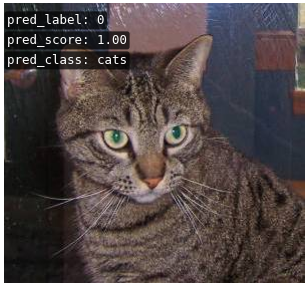

In [34]:
%matplotlib inline
# 验证训练好的模型

img = mmcv.imread('data/cats_dogs_dataset/training_set/training_set/cats/cat.1.jpg')

model.cfg = cfg
result = inference_model(model, img)

show_result_pyplot(model, img, result)